In [230]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./mp'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


./mp/.DS_Store
./mp/samples/493718.png
./mp/samples/578975.png
./mp/samples/519637.png
./mp/samples/592599.png
./mp/samples/611172.png
./mp/samples/420302.png
./mp/samples/868081.png
./mp/samples/586710.png
./mp/samples/967615.png
./mp/samples/130537.png
./mp/samples/834677.png
./mp/samples/254221.png
./mp/samples/668061.png
./mp/samples/425668.png
./mp/samples/797300.png
./mp/samples/263062.png
./mp/samples/428775.png
./mp/samples/149356.png
./mp/samples/217682.png
./mp/samples/933479.png
./mp/samples/790085.png
./mp/samples/798432.png
./mp/samples/748565.png
./mp/samples/613574.png
./mp/samples/440143.png
./mp/samples/678464.png
./mp/samples/770158.png
./mp/samples/492373.png
./mp/samples/918991.png
./mp/samples/947891.png
./mp/samples/442409.png
./mp/samples/828000.png
./mp/samples/509057.png
./mp/samples/222937.png
./mp/samples/342230.png
./mp/samples/150707.png
./mp/samples/662277.png
./mp/samples/874756.png
./mp/samples/592470.png
./mp/samples/894850.png
./mp/samples/435785.png
.

# Import Libraries

In [231]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd

import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.backend import ctc_batch_cost, ctc_decode
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

# Load Data

In [232]:
root_dir = "./mp/samples"

In [233]:
image_paths = []
labels = []

for file in tqdm.tqdm(os.listdir(root_dir)):
    filepath = os.path.join(root_dir, file)
    label = filepath.split("/")[-1].split(".")[0]

    image_paths.append(filepath)
    labels.append(label)

100%|██████████| 132/132 [00:00<00:00, 656759.35it/s]


In [234]:
images_df = pd.DataFrame({"image_path": image_paths, "label": labels})
images_df.head()

,image_path,label
0,./mp/samples/493718.png,493718
1,./mp/samples/578975.png,578975
2,./mp/samples/519637.png,519637
3,./mp/samples/592599.png,592599
4,./mp/samples/611172.png,611172


In [235]:
characters = set(char for label in labels for char in label)
print("Characters:\n", characters)

Characters:
 {'0', '7', '4', '3', '5', '2', '1', '6', '8', '9'}


# Preprocess

In [236]:
char_to_num = layers.StringLookup(
    vocabulary = list(characters),
    num_oov_indices = 0,
    mask_token = None
)

In [237]:
pd.DataFrame({"char": char_to_num.get_vocabulary(),
              "num": np.arange(1, len(char_to_num.get_vocabulary())+1)})

,char,num
0,0,1
1,7,2
2,4,3
3,3,4
4,5,5
5,2,6
6,1,7
7,6,8
8,8,9
9,9,10


In [238]:
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

In [239]:
def encode_single_sample(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [50, 200])
    image = tf.transpose(image, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return image, label

In [240]:
def process_dataset(X, y):
    images = []
    labels = []
    for img_path, label in zip(X, y):
        img, lbl = encode_single_sample(img_path, label)
        images.append(img.numpy())
        labels.append(lbl.numpy())
    return np.array(images), np.array(labels)

In [241]:
X_train, X_test, y_train, y_test = train_test_split(np.array(image_paths), np.array(labels), test_size=0.15, random_state=42)

In [242]:
X_train_processed, y_train_processed = process_dataset(X_train, y_train)
X_test_processed, y_test_processed = process_dataset(X_test, y_test)

In [243]:
X_train_input = {"Input": X_train_processed, "Label": y_train_processed}
X_test_input = {"Input": X_test_processed, "Label": y_test_processed}

# Visualization

In [244]:
def visualize_df(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(10, 5))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['image_path']].values[0]
            label = df.loc[a][["label"]].values[0]
            
            image = Image.open(img_path).convert('RGB')
            
            ax.imshow(image)
            ax.set_title(f"CAPTCHA: {label}")
            ax.axis('off')
            
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

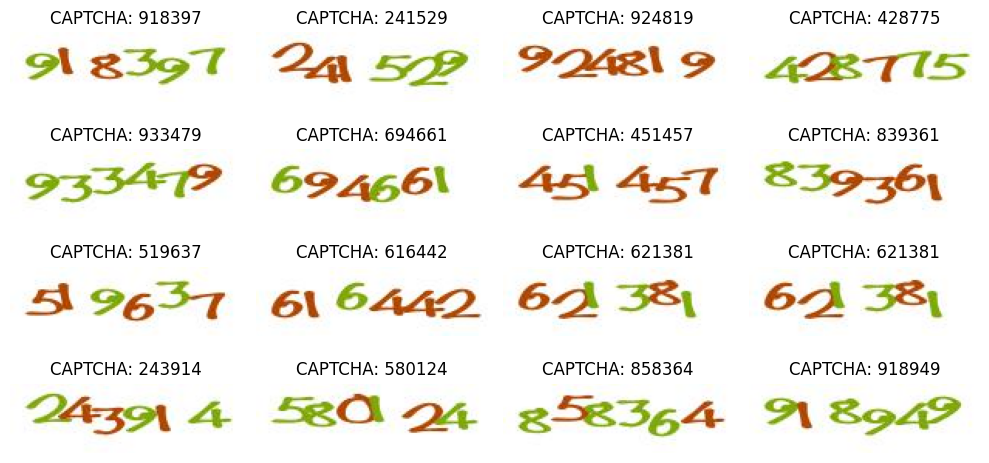

In [245]:
visualize_df(images_df)

# Model

In [246]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_length = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_length, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_length, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [247]:
input_layer = layers.Input(shape=(200, 50, 1), name="Input", dtype="float32")
label_layer = layers.Input(shape=(None,), name="Label", dtype="float32")

conv2_1 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(input_layer)
max2_1 = layers.MaxPooling2D(strides=(2, 2))(conv2_1)

conv2_2 = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(max2_1)
max2_2 = layers.MaxPooling2D(strides=(2, 2))(conv2_2)

reshape_layer = layers.Reshape(target_shape=((200 // 4), (50 // 4) * 64))(max2_2)
dense_1 = layers.Dense(units=64, activation="relu")(reshape_layer)
drop_1 = layers.Dropout((0.2))(dense_1)

bilstm_1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(drop_1)
bilstm_2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(bilstm_1)

output_layer = layers.Dense(len(characters) + 1, activation="softmax", name="Output")(bilstm_2)

output = CTCLayer(name="ctc_loss")(label_layer, output_layer)

model = models.Model(inputs=[input_layer, label_layer], outputs=output, name="OCR")

In [248]:
model.compile(optimizer=optimizers.Adam())

In [249]:
model.summary()

Model: "OCR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 200, 50,   │        320 │ Input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 100, 25,   │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 100, 25,   │     18,496 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 50, 12,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 50, 768)   │          0 │ max_pooling2d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 50, 64)    │     49,216 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 50, 64)    │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_18    │ (None, 50, 256)   │    197,632 │ dropout_9[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_19    │ (None, 50, 128)   │    164,352 │ bidirectional_18… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 50, 11)    │      1,419 │ bidirectional_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 11)    │          0 │ Label[0][0],      │
│                     │                   │            │ Output[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 431,435 (1.65 MB)

 Trainable params: 431,435 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

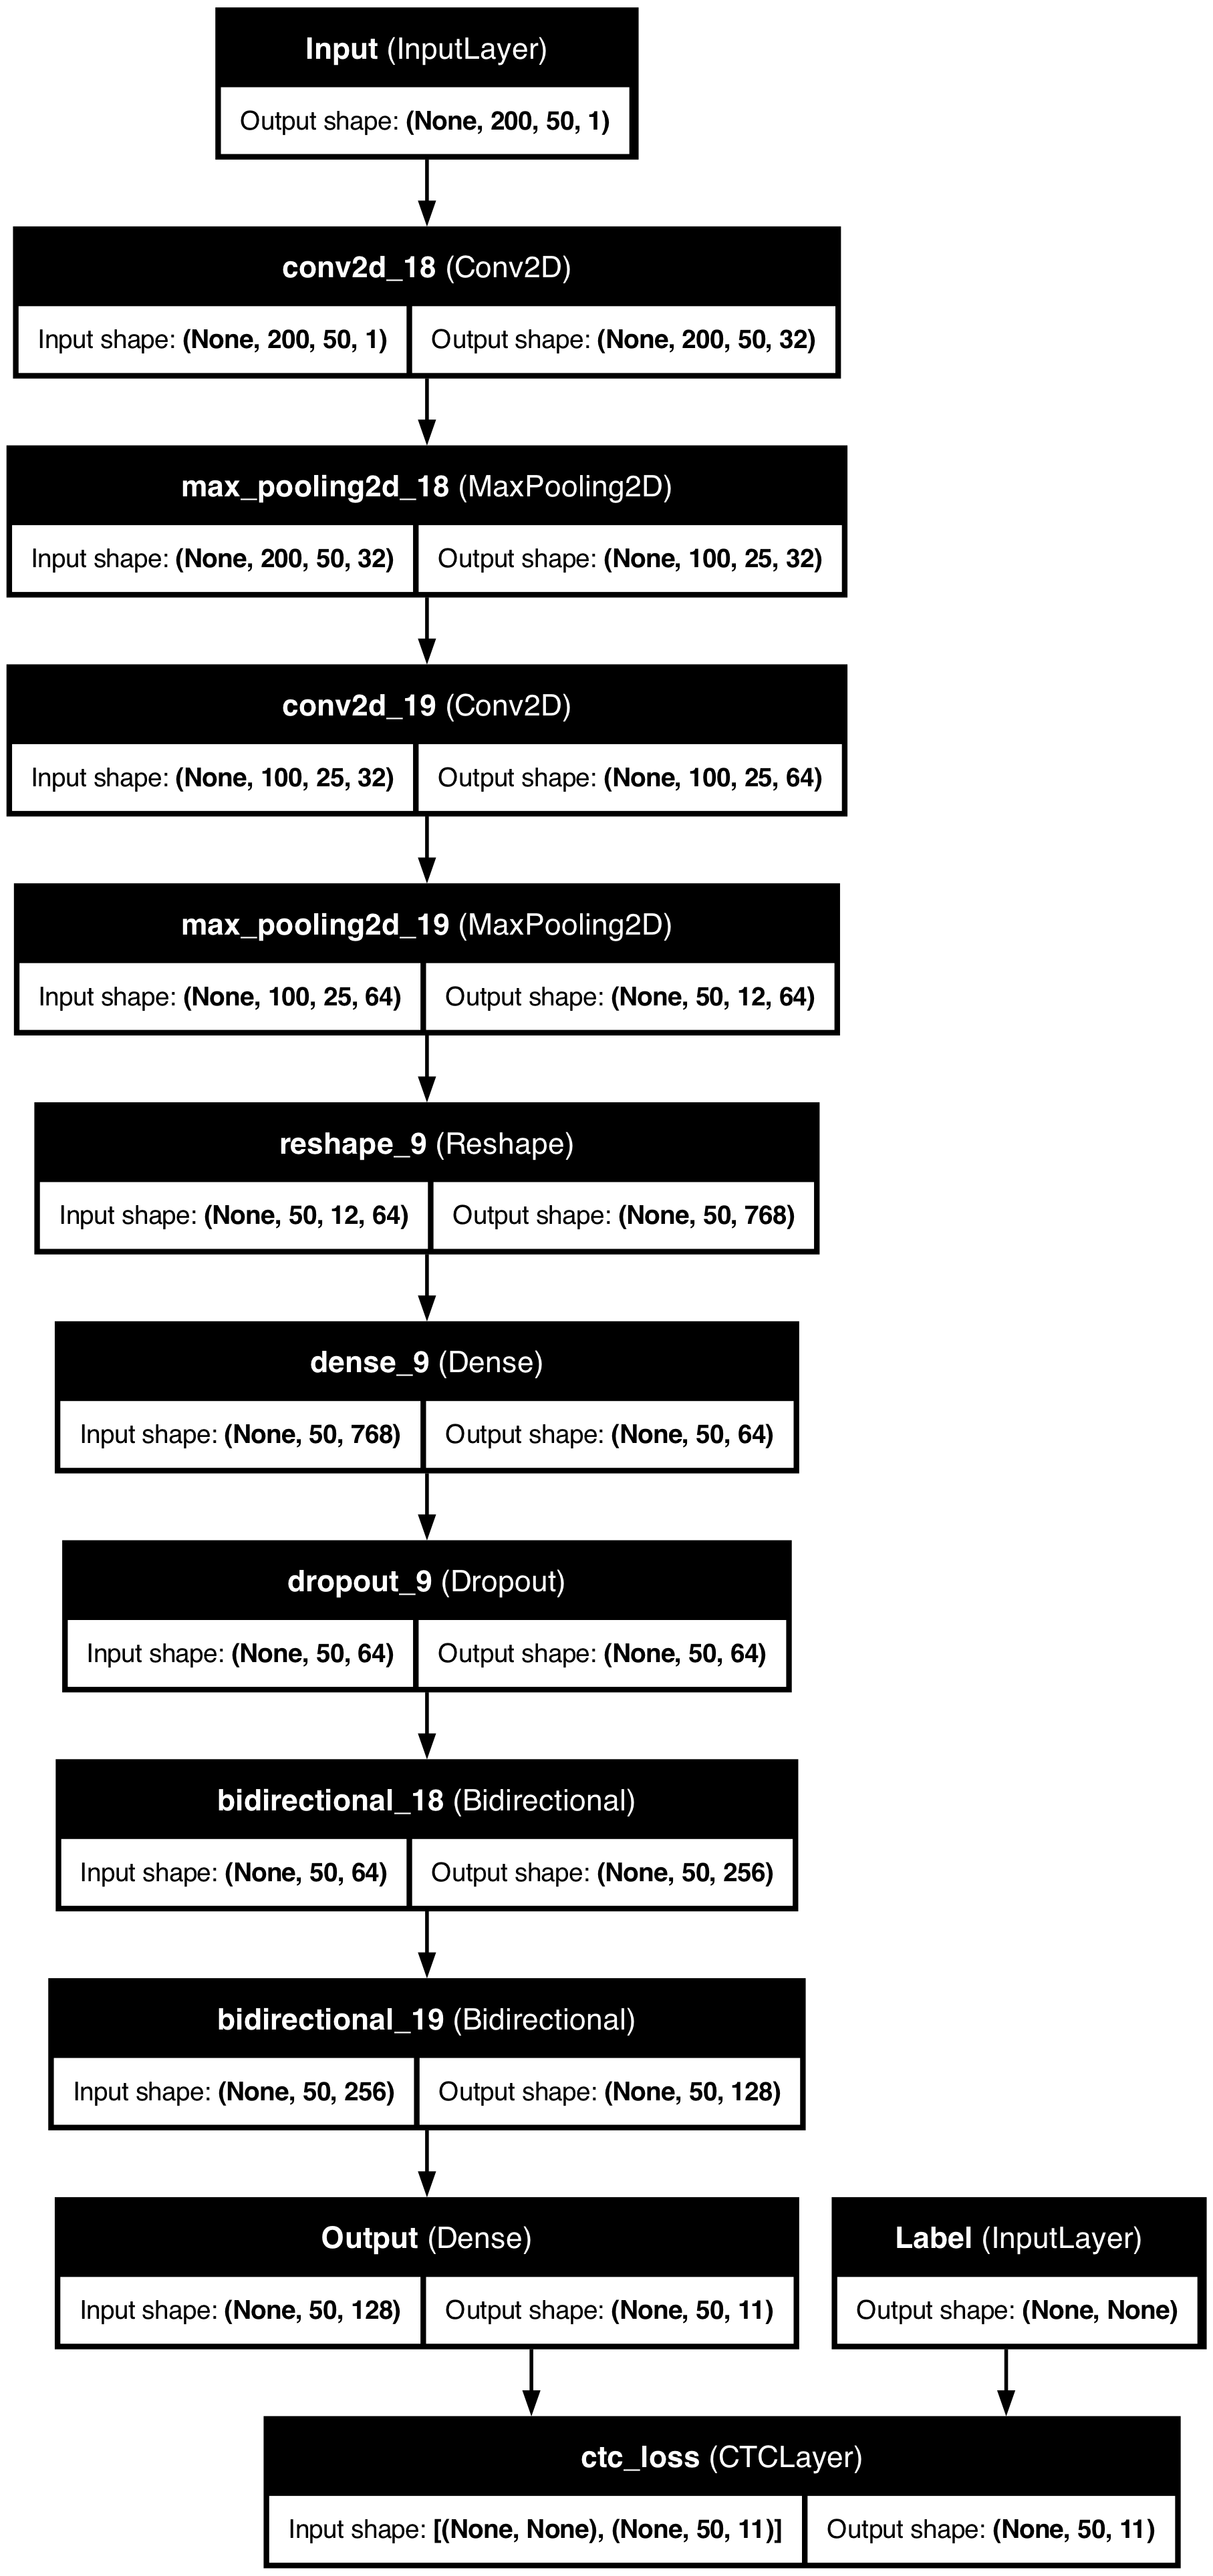

In [250]:
plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True)

# Train

In [251]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5)

In [252]:
history = model.fit(
    X_train_input,
    y_train_processed,
    validation_data=(X_test_input, y_test_processed),
    epochs=300,
    batch_size=32,
    #callbacks=[early_stopping]
)
model.save("captcha_mpets.keras")

Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - loss: 2106.0007 - val_loss: 330.4145
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 528.4242 - val_loss: 407.6346
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 551.5853 - val_loss: 342.7358
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 496.3973 - val_loss: 316.8185
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 505.3956 - val_loss: 316.9721
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 486.2614 - val_loss: 321.4803
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 488.5739 - val_loss: 317.0627
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 485.8483 - val_loss: 313.3430
Epoch 9/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - loss: 483.9316 - val_loss: 313.2942
Epoch 10/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 485.2971 - val_loss: 313.8499
Epoch 11/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 483.3011 - val_loss: 314.8088
Epoch 12/300
4/4 ━

# Results

In [253]:
# model = models.load_model("captcha_mpets.keras", custom_objects={"CTCLayer": CTCLayer})

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'OCR', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 200, 50, 1], 'dtype': 'float32', 'sparse': False, 'name': 'Input'}, 'registered_name': None, 'name': 'Input', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_18', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 200, 50, 1]}, 'name': 'conv2d_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 200, 50, 1], 'dtype': 'float32', 'keras_history': ['Input', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_18', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 200, 50, 32]}, 'name': 'max_pooling2d_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 200, 50, 32], 'dtype': 'float32', 'keras_history': ['conv2d_18', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_19', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 25, 32]}, 'name': 'conv2d_19', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 25, 32], 'dtype': 'float32', 'keras_history': ['max_pooling2d_18', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_19', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 100, 25, 64]}, 'name': 'max_pooling2d_19', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100, 25, 64], 'dtype': 'float32', 'keras_history': ['conv2d_19', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'reshape_9', 'trainable': True, 'dtype': 'float32', 'target_shape': [50, 768]}, 'registered_name': None, 'build_config': {'input_shape': [None, 50, 12, 64]}, 'name': 'reshape_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 50, 12, 64], 'dtype': 'float32', 'keras_history': ['max_pooling2d_19', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_9', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 50, 768]}, 'name': 'dense_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 50, 768], 'dtype': 'float32', 'keras_history': ['reshape_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_9', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 50, 64]}, 'name': 'dropout_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 50, 64], 'dtype': 'float32', 'keras_history': ['dense_9', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Bidirectional', 'config': {'name': 'bidirectional_18', 'trainable': True, 'dtype': 'float32', 'merge_mode': 'concat', 'layer': {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'forward_lstm_18', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': True, 'units': 128, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None, 'shared_object_id': 14633949680}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'OrthogonalInitializer', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None, 'shared_object_id': 14633949776}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None, 'shared_object_id': 14633949872}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.25, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 50, 64]}}, 'backward_layer': {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'backward_lstm_18', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': True, 'stateful': False, 'unroll': False, 'zero_output_for_mask': True, 'units': 128, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None, 'shared_object_id': 14633952752}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'OrthogonalInitializer', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None, 'shared_object_id': 14633952848}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None, 'shared_object_id': 14633952944}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.25, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 50, 64]}}}, 'registered_name': None, 'build_config': {'input_shape': [None, 50, 64]}, 'name': 'bidirectional_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 50, 64], 'dtype': 'float32', 'keras_history': ['dropout_9', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Bidirectional', 'config': {'name': 'bidirectional_19', 'trainable': True, 'dtype': 'float32', 'merge_mode': 'concat', 'layer': {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'forward_lstm_19', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': True, 'units': 64, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None, 'shared_object_id': 14634058944}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'OrthogonalInitializer', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None, 'shared_object_id': 14634059040}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None, 'shared_object_id': 14634059136}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.25, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 50, 256]}}, 'backward_layer': {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'backward_lstm_19', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': True, 'stateful': False, 'unroll': False, 'zero_output_for_mask': True, 'units': 64, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None, 'shared_object_id': 14634062016}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'OrthogonalInitializer', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None, 'shared_object_id': 14634062112}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None, 'shared_object_id': 14634062208}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.25, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 50, 256]}}}, 'registered_name': None, 'build_config': {'input_shape': [None, 50, 256]}, 'name': 'bidirectional_19', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 50, 256], 'dtype': 'float32', 'keras_history': ['bidirectional_18', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, None], 'dtype': 'float32', 'sparse': False, 'name': 'Label'}, 'registered_name': None, 'name': 'Label', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'Output', 'trainable': True, 'dtype': 'float32', 'units': 11, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 50, 128]}, 'name': 'Output', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 50, 128], 'dtype': 'float32', 'keras_history': ['bidirectional_19', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'CTCLayer', 'config': {'name': 'ctc_loss', 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'CTCLayer', 'build_config': {'input_shape': [None, None]}, 'name': 'ctc_loss', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, None], 'dtype': 'float32', 'keras_history': ['Label', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 50, 11], 'dtype': 'float32', 'keras_history': ['Output', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['Input', 0, 0], ['Label', 0, 0]], 'output_layers': [['ctc_loss', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': None, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: <class '__main__.CTCLayer'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'CTCLayer', 'config': {'name': 'ctc_loss', 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'CTCLayer', 'build_config': {'input_shape': [None, None]}, 'name': 'ctc_loss', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, None], 'dtype': 'float32', 'keras_history': ['Label', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 50, 11], 'dtype': 'float32', 'keras_history': ['Output', 0, 0]}}], 'kwargs': {}}]}.

Exception encountered: Error when deserializing class 'CTCLayer' using config={'name': 'ctc_loss', 'trainable': True, 'dtype': 'float32'}.

Exception encountered: CTCLayer.__init__() got an unexpected keyword argument 'trainable'

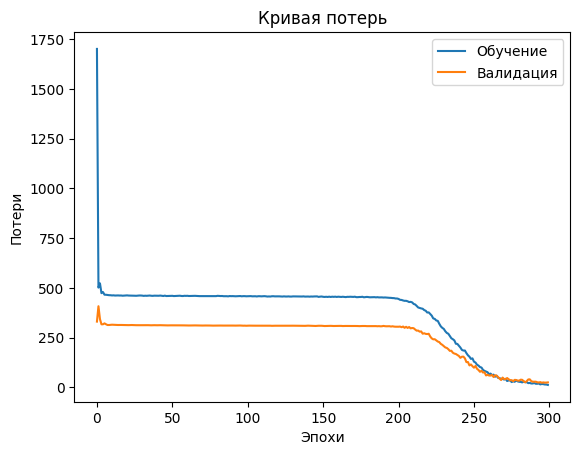

In [254]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend(["Обучение", "Валидация"])
plt.title("Кривая потерь")
plt.show()

# Test

In [255]:
preds = model.predict(X_test_input)
input_length = np.ones(preds.shape[0]) * preds.shape[1]
results = ctc_decode(preds, input_length=input_length, greedy=True)[0][0][:, :6]
pred_texts = []
for result in results:
    res = tf.strings.reduce_join(num_to_char(result+1)).numpy().decode("utf-8")
    pred_texts.append(res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


In [259]:
pred_df = pd.DataFrame({
    "Путь до файла": X_test,
    "Ожидалось": y_test,
    "Результат": pred_texts,
    "Совпадение": [1 if y_test[i] == pred_texts[i] else 0 for i in range(len(y_test))]
})
print(X_test)

['./mp/samples/184963.png' './mp/samples/269469.png'
 './mp/samples/933479.png' './mp/samples/828000.png'
 './mp/samples/186763.png' './mp/samples/938051.png'
 './mp/samples/177547.png' './mp/samples/858364.png'
 './mp/samples/239266.png' './mp/samples/770158.png'
 './mp/samples/818738.png' './mp/samples/492373.png'
 './mp/samples/640760.png' './mp/samples/611172.png'
 './mp/samples/147614.png' './mp/samples/507561.png'
 './mp/samples/662277.png' './mp/samples/243914.png'
 './mp/samples/435785.png' './mp/samples/694661.png']


In [261]:
pred_df.head(1000)

,Путь до файла,Ожидалось,Результат,Совпадение
0,./mp/samples/184963.png,184963,1463[UNK][UNK],0
1,./mp/samples/269469.png,269469,269469,1
2,./mp/samples/933479.png,933479,933979,0
3,./mp/samples/828000.png,828000,828000,1
4,./mp/samples/186763.png,186763,186763,1
5,./mp/samples/938051.png,938051,938051,1
6,./mp/samples/177547.png,177547,176554,0
7,./mp/samples/858364.png,858364,858364,1
8,./mp/samples/239266.png,239266,239266,1
9,./mp/samples/770158.png,770158,770158,1


In [ ]:
pred_df.to_excel("preds.xlsx")

In [ ]:
def visualize_predictions(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(10, 5))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['image_path']].values[0]
            label = df.loc[a][["label"]].values[0]
            pred = df.loc[a][["pred"]].values[0]
            
            image = Image.open(img_path).convert('RGB')
            
            ax.imshow(image)
            ax.set_title(f"Ожидалось: {label}\nРезультат: {pred}")
            ax.axis('off')
            
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_predictions(pred_df)